# InSituPy demonstration - Register images

This notebook demonstrates the registration of images from H&E, IHC or IF stainings that were performed on the same slide as the Xenium In Situ measurements. It is assumed that the images which are about to be registered, contain the same tissue as the spatial transcriptomics data. 

However, in a Xenium In Situ workflow, a slide often contains multiple tissue sections. While the spatial transcriptomics data is separated usually during the run, the histological stainings contain all sections in one whole slide image. To extract the individual images of the histologically stained tissue sections, two workflows were tested:
1. Annotation and naming of the individual tissue sections in QuPath, followed by the use of the `.groovy` script stored in `InSituPy\scripts\export_annotations_OME-TIFF.groovy`
2. Using a napari-based approach demonstrated in `XX_InSituPy_extract_individual_images.ipynb`


In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from insitupy import register_images

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to `InSituData` using the `read_xenium` function or directly using the downloading function.

In [3]:
from insitupy.datasets import human_breast_cancer
from insitupy import CACHE

### Load the dataset directly from the downloading function...

In [4]:
xd = human_breast_cancer()

This dataset exists already. Download is skipped. To force download set `overwrite=True`.
Loading cells...
Loading images...
Loading transcripts...
Image exists. Checking md5sum...
The md5sum matches. Download is skipped. To force download set `overwrite=True`.
Image exists. Checking md5sum...
The md5sum matches. Download is skipped. To force download set `overwrite=True`.
Corresponding image data can be found in C:\Users\ge37voy\.cache\InSituPy\demo_datasets\hbreastcancer\unregistered_images
For this dataset following images are available:
slide_id__hbreastcancer__HE__histo.ome.tiff
slide_id__hbreastcancer__CD20_HER2_DAPI__IF.ome.tiff


### ... or use the `read_xenium` function and the path to the Xenium data directory

In [5]:
xd = read_xenium(CACHE / "demo_datasets/hbreastcancer\output-XETG00000__slide_id__hbreastcancer")

Loading cells...
Loading images...
Loading transcripts...


In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\demo_datasets\hbreastcancer\output-XETG00000__slide_id__hbreastcancer
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 42638083 x 7

### Prepare the paths to the unregistered images

Here the unregistered images were downloaded by the `human_breast_cancer` downloading function and saved in a folder `unregistered_images`.

In [7]:
# prepare paths
if_to_be_registered = CACHE / "demo_datasets/hbreastcancer" / "unregistered_images/slide_id__hbreastcancer__CD20_HER2_DAPI__IF.ome.tif"
he_to_be_registered = CACHE / "demo_datasets/hbreastcancer" / "unregistered_images/slide_id__hbreastcancer__HE__histo.ome.tif"

### Register images automatically

Since _Xenium In Situ_ is a non-destructive method, it is possible to stain and image the tissue after the in situ sequencing analysis. However, this is done outside of the _Xenium_ machine and requires subsequent registration. `InSituPy` contains a automatic image registration pipeline based on the "Scale-invariant feature transform" (SIFT) algorithm ([publication](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94)).

Using the SIFT algorithm, common features between the template (_Xenium_ DAPI image) and the subsequently acquired images are detected and used to calculate a transformation matrix. This transformation matrix is then used to register the images to the template.

This example shows the result of SIFT with lines connecting the common features of two images:

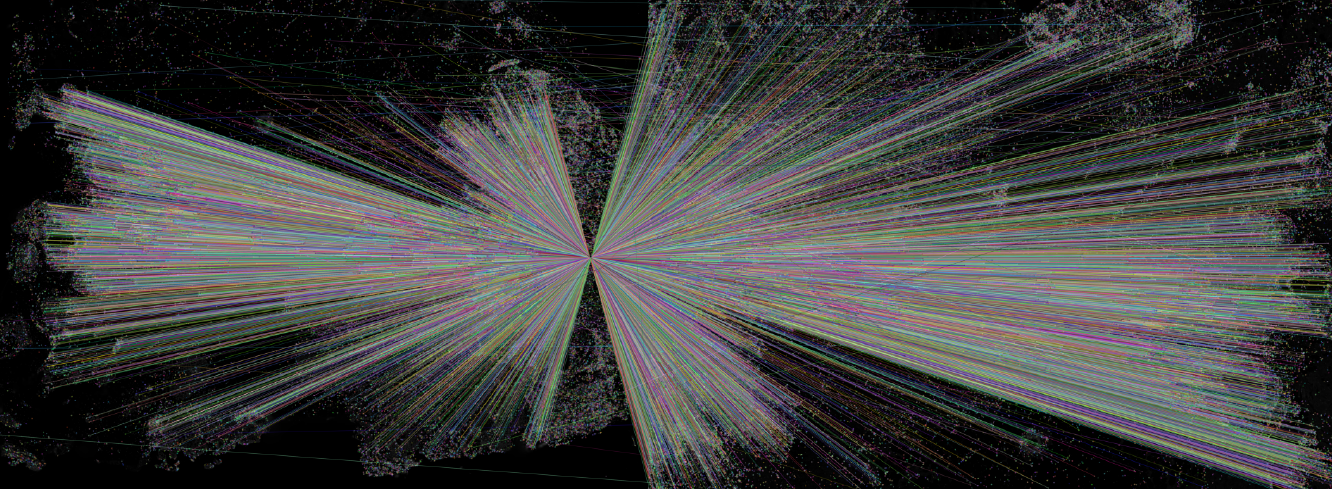*Common features extracted by SIFT algorithm*

Depending on the type of the images different preprocessing steps are necessary:
1. **Histological images** (H&E or IHC): These techniques result in an RGB image. To allow registration with the _Xenium_ DAPI image, color deconvolution is performed to extract the hematoxylin channel containing the nuclei.
2. **IF images**: Depending on the number of immunofluorescent stains, this method results in multiple grayscale images. For the method to work it is important that one of the channels contains signal from a nuclei stain (e.g. DAPI). For the registration, this channel is selected and used to detect common features with SIFT and calculate the transformation matrix. The other channels are then registered using the same transformation matrix.

#### Input files

The images can be either in `.tif` or `.ome.tif` format.

#### Output generated by the registration pipeline

1. **Registered images**: The registered images are saved as `.ome.tif` into a folder called `registered_images` in the parent directory of the folder containing the _Xenium_ data. The images files are named as follows: `slide_id__sample_id__name__registered.ome.tif`.
2. **Transformation matrix**: The transformation matrix is saved as `.csv` into a folder called `registration_qc` in the parent directory of the folder containing the _Xenium_ data. The file name ends with `__T.pdf`.
3. **Common features**: A representation of the common features between the registered image and the template is saved as well in the `registration_qc` folder as `.pdf` with the file name ending with `__common_features`.

```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    ├───registered_images
    │       slide_id__sample_id__name__registered.ome.tif <-- 1.
    ├───registration_qc
    │       slide_id__sample_id__name__T.csv <-- 2.
    │       slide_id__sample_id__name__common_features.pdf <-- 3.
    └───unregistered_images
```


## Registration of IF images

In [11]:
register_images(
    data=xd,
    image_to_be_registered=if_to_be_registered,
    image_type="IF",
    channel_names=['CD20', 'HER2', 'DAPI'],
    channel_name_for_registration="DAPI",
    template_image_name="nuclei",
    save_registered_images=True
    )

	Processing following IF images: CD20, HER2, DAPI
		Loading images to be registered...
		Select image with nuclei from IF image (channel: 2)
		Load image into memory...
		Rescale image and template to save memory.
			Rescaled to following dimensions: (3314, 4827)
			Rescaled to following dimensions: (3412, 4688)
		Convert scaled images to 8 bit
		Extract common features from image and template
		2025-02-04 17:11:30: Get features...
			Method: SIFT...
		2025-02-04 17:11:35: Compute matches...
		2025-02-04 17:11:40: Filter matches...
			Sufficient number of good matches found (10331).
		2025-02-04 17:11:40: Display matches...
		2025-02-04 17:11:42: Fetch keypoints...
		2025-02-04 17:11:42: Estimate 2D affine transformation matrix...
		2025-02-04 17:11:42: Register image by affine transformation...
		Save OME-TIFF to C:\Users\ge37voy\.cache\InSituPy\demo_datasets\hbreastcancer\registered_images\0001879__Replicate 1__CD20__registered.ome.tif
		Save QC files to C:\Users\ge37voy\.cache\InSit

In [12]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\demo_datasets\hbreastcancer\output-XETG00000__slide_id__hbreastcancer
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 42638083 x 7

## Registration of H&E images

In [13]:
register_images(
    data=xd,
    image_to_be_registered=he_to_be_registered,
    image_type="histo",
    channel_names='HE',
    template_image_name="nuclei",
    save_registered_images=True,
    min_good_matches=10
    )

	Processing following histo images: HE
		Loading images to be registered...
		Run color deconvolution
		Rescale image and template to save memory.
			Rescaled to following dimensions: (3548, 4507)
			Rescaled to following dimensions: (3412, 4688)
		Convert scaled images to 8 bit
		Extract common features from image and template
		2025-02-04 17:12:31: Get features...
			Method: SIFT...
		2025-02-04 17:12:41: Compute matches...
		2025-02-04 17:12:44: Filter matches...
			Number of good matches (0) below threshold (10). Flipping is tested.
		Vertical flip is tested.
			Method: SIFT...
		2025-02-04 17:12:51: Compute matches...
		2025-02-04 17:12:53: Filter matches...
			Sufficient number of good matches found (13).
		2025-02-04 17:12:53: Display matches...
		2025-02-04 17:12:53: Fetch keypoints...
		2025-02-04 17:12:53: Estimate 2D affine transformation matrix...
		Image is flipped vertically
		2025-02-04 17:12:53: Register image by affine transformation...
		Save OME-TIFF to C:\Users\ge37

In [14]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\demo_datasets\hbreastcancer\output-XETG00000__slide_id__hbreastcancer
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 42638083 x 7

## Working with an `InSituPy` project

To allow a simple and structured saving workflow, `InSituPy` provides two saving functions:
- `saveas()`
- `save()`


### Save as `InSituPy` project

In [15]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [16]:
xd.saveas(insitupy_project, overwrite=True)

Saving data to demo_dataset\demo_insitupy_project


C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")
C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")


Saved.


### Save `InSituPy` project with downscaled image data

Since the image data is very large and not required during most of the trancriptomic analysis, we can downscale the image data to save disk space.

In [17]:
insitupy_project_downscaled = Path("demo_dataset/demo_insitupy_project_downscaled")

In [18]:
xd.saveas(
    insitupy_project_downscaled, overwrite=True,
    images_max_resolution=1 # in µm/pixel
    )

Saving data to demo_dataset\demo_insitupy_project_downscaled
Downscale image to 1 µm per pixel by factor 4.705882352941177
Downscale image to 1 µm per pixel by factor 4.705882352941177
Downscale image to 1 µm per pixel by factor 4.705882352941177
Downscale image to 1 µm per pixel by factor 4.705882352941177
Downscale image to 1 µm per pixel by factor 4.705882352941177


C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")
C:\Users\ge37voy\Github\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")


Saved.


### Reload from `InSituPy` project

From the `InSituPy` project we can now load only the modalities that we need for later analyses. Due to an optimized file structure using `zarr` and `dask`, this makes loading and visualization of the data more efficient compared to doing this directly from the xenium bundle.

### Load all required data

Next, we have to make sure that all data modalities that are required for the subsequent analyses are loaded. In our case it is the cellular data and the image data. If a modality is missing, one can load it with `.load_{modality}`.

In [19]:
from insitupy import InSituData

In [20]:
xd = InSituData.read(insitupy_project)
xd_ds = InSituData.read(insitupy_project_downscaled)

In [21]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy

No modalities loaded.

In [22]:
xd_ds

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project_downscaled
Metadata file:	.ispy

No modalities loaded.

In [23]:
xd_ds.load_cells()
xd_ds.load_images()

Loading images...


In [24]:
xd_ds.show()